### Import Dependencies 

In [7]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry
import os
import glob
from tqdm import tqdm
from astropy.time import Time
from datetime import timedelta
import matplotlib.dates as mdates
import time as tm
import datetime

# Setup
Here is where you set the star names and coordinates, image and folder paths, and aperture settings that the reset of the notebook relies upon.

In [9]:
Star_Name = 'HAT-P-22'
Comp_Star_Name = 'HD 233728'

test_image = fits.open('../data/HAT-P-22/images/_DCM0001.NEF_bin2x2_aligned.fit')

image_folder = '../data/HAT-P-22/images/'
file_pattern = '_DCM*.NEF_bin2x2_aligned.fit' 

star_x, star_y = 1718.5, 1031.6
#comp_x, comp_y = 2225.2, 1330.1
#comp_x, comp_y = 1356.5, 904.7
comp_x, comp_y = 1518.8, 746.3

positions = [(star_x, star_y) , (comp_x, comp_y)]

aperture_radius = 10
annuli_inner = 12
annuli_outer = 15

bias_files = ['../data/HAT-P-22/calibration frames/_DCM9870_bias.NEF.fits','../data/HAT-P-22/calibration frames/_DCM9871_bias.NEF.fits']

graph_folder = '../graphs'

fits_files = []
search_path = os.path.join(image_folder, file_pattern)
fits_files = sorted(glob.glob(search_path))
image_length=len(fits_files)
print(image_length)

1


## Load Sample Image
Before any analysis is done, a sample image is loaded to ensure everything is working correctly. Only the green channel is rendered.

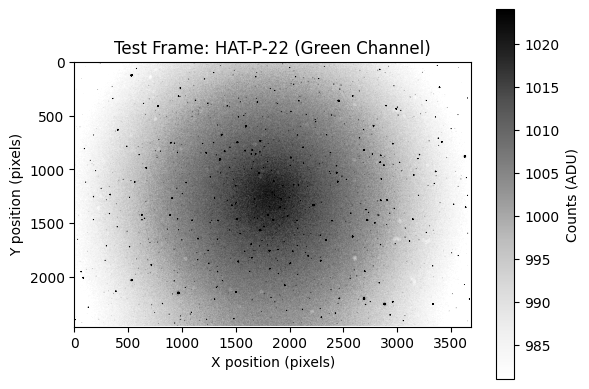

In [10]:
test_image_data = test_image[0].data
test_image_data = test_image_data[1,:,:]
plt.figure()
plt.imshow(test_image_data, 
           vmin=np.percentile(test_image_data, 10), 
           vmax=np.percentile(test_image_data, 99),
           #norm = LogNorm(), 
           cmap='Greys')

plt.xlabel('X position (pixels)')
plt.ylabel('Y position (pixels)')
cbar = plt.colorbar()
cbar.set_label('Counts (ADU)')
plt.title(f'Test Frame: {Star_Name} (Green Channel)')

plt.savefig(f'../graphs/{Star_Name}-Test_image.png', dpi=300, bbox_inches='tight')
plt.show()


## Zoomed in Section
To ensure the aperture and annulus are set correctly, we zoom into the portion of the image that contains the target and comparison star.

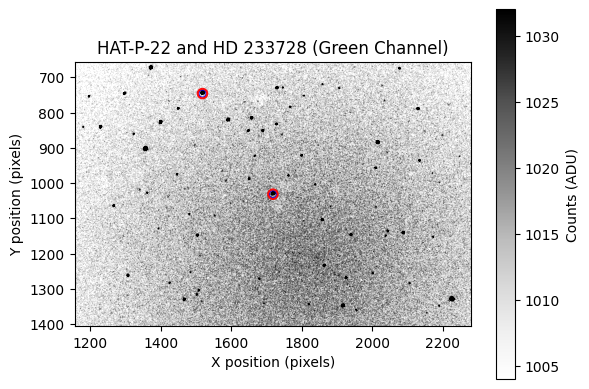

In [11]:
zoom_height = 750
zoom_width = zoom_height * 1.5
section_ymin, section_ymax = (star_y - zoom_height/2), (star_y + zoom_height/2)
section_xmin, section_xmax = (star_x - zoom_width/2), (star_x + zoom_width/2)
section = test_image_data[int(section_ymin):int(section_ymax), int(section_xmin):int(section_xmax)]

apertures = CircularAperture(positions, r=aperture_radius)
annuli = CircularAnnulus(positions, r_in=annuli_inner, r_out=annuli_outer)

plt.imshow(test_image_data, vmin=np.percentile(section, 10), vmax=np.percentile(section, 99), cmap='Greys')
apertures.plot(color = 'blue', lw = .7, alpha = 1);
annuli.plot(color = 'red', lw = .7, alpha = 1);
plt.xlabel('X position (pixels)')
plt.ylabel('Y position (pixels)')
cbar = plt.colorbar()
cbar.set_label('Counts (ADU)')
plt.title(f'{Star_Name} and {Comp_Star_Name} (Green Channel)')


plt.xlim(section_xmin,section_xmax)
plt.ylim(section_ymax,section_ymin)
plt.savefig(f'../graphs/{Star_Name}_{Comp_Star_Name}-Zoomed_Image.png', dpi=300, bbox_inches='tight')



# Image Analysis

## Photometry Method
The equation used in this notebook to calculate the flux of the object is
$$
C_{\text{obj}}=C_{\text{aper}}-C_{\text{sky}}=C_{\text{aper}}-N_{\text{aper}}\left( \frac{C_{\text{annul}}}{N_{\text{annul}}}  \right).
$$
$C_{\text{obj}} =\text{Counts of Object}$, $\quad C_{\text{aper}} =\text{Counts in aperture}$, $\quad C_{\text{sky}} =\text{Background sky count}$, 

$C_{\text{annul}} =\text{Counts in annulus}$, $\quad N_{\text{aper}} =\text{Pixels in aperture}$, $\quad N_{\text{annul}} =\text{Pixels in annulus}$

In this code block each image is loaded, analyzed, and stores its data. Note that at this point the time data is stored as utc in an `MJD` format.

In [12]:
times = []
C_target = []
C_comp = []
C_target_sky = []
C_comp_sky = []

for i, filename in tqdm(enumerate(fits_files), total=len(fits_files)):
    with fits.open(filename) as open_file:
        #again only loads green channel
        data = open_file[0].data[1, :, :].astype(np.float32)
        time = open_file[0].header['DATE-OBS']   
        t_obj = Time(time, format='isot', scale='utc')

    phot_table = aperture_photometry(data, [apertures, annuli])

    C_aper = phot_table['aperture_sum_0'] 
    C_annul = phot_table['aperture_sum_1'] 
    N_aper = apertures.area
    N_annul = annuli.area 

    C_sky = N_aper * (C_annul/N_annul)
    C_obj = C_aper - C_sky

    

    C_target.append(C_obj[0])
    C_comp.append(C_obj[1])

    C_target_sky.append(C_sky[0])
    C_comp_sky.append(C_sky[1])

    times.append(t_obj.mjd)

    
utc_array = np.array(times)
target_counts = np.array(C_target)
comp_counts = np.array(C_comp)
target_sky_counts = np.array(C_target_sky)
comp_sky_counts = np.array(C_comp_sky)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.91it/s]


# Saving/Loading Data
## Saving
Saving the image data to a file helps save time and allows for easier comparison between data sets without having to redo the analysis. Saving the data is optional and can be skipped.

In [13]:
save_dir = f'../data/{Star_Name}/light_curves'
os.makedirs(save_dir, exist_ok=True)
save_filename = f'{Star_Name}_lightcurve-{Comp_Star_Name}-r_{aperture_radius}-rin_{annuli_inner}-rout_{annuli_outer}-n_{image_length}.npz'
full_save_path = os.path.join(save_dir, save_filename)

np.savez(full_save_path, 
        target=target_counts, 
        comp=comp_counts, 
        time=utc_array,
        target_sky = target_sky_counts,
        comp_sky = comp_sky_counts
        )
        
print(f'saved {save_filename}')

saved HAT-P-22_lightcurve-HD 233728-r_10-rin_12-rout_15-n_1.npz


## Loading
If the data file already exists, instead of redoing the analysis it can be loaded here. For example a sample data set is currently included that contains the information of 664 images.

In [14]:
load_filename = 'HAT-P-22_lightcurve-HD 233728-r_10-rin_12-rout_15-n_665.npz'
#set the above value to 'save_filename' for default behavior

loaded_data = np.load(f'../data/{Star_Name}/light_curves/{load_filename}')
target_counts = loaded_data['target']
comp_counts = loaded_data['comp']
utc_array = loaded_data['time']
target_sky_counts = loaded_data['target_sky']
comp_sky_counts = loaded_data['comp_sky']
print(f'loaded ../data/{Star_Name}/light_curves/{load_filename}')

loaded ../data/HAT-P-22/light_curves/HAT-P-22_lightcurve-HD 233728-r_10-rin_12-rout_15-n_665.npz


# Pre Plotting Step
Before the image can be plotted it must undergo a series of steps.
## Modifying Variables 
The time data which was stored as an array is converted to a `datetime` object before being shifted to match the timezone where the image was taken. The data is then ordered by time to fix any out of order data points. If there are erroneous images, for example the images being obstructed by a tree or the star getting too close to the horizon, a mask can be applied so only the correct images are plotted. 

Then the light curves are normalized and compared. The power of differential photometry comes from using a non variable neighboring star to 'calibrate' the light curve of the target star. By dividing `target_counts` by `comp_counts` we solve for any systematic changes to the luminosity, such as changing light pollution or weather. 
$$
\text{Relative Brightness} = \frac{\text{Target Star Brightness}}{\text{Comparison Star Brightness}}
$$

Normalizing the light curves allows them to be compared to each other.

If the transit start and end times are known they can also be inputted here. 

In [15]:
t_obj_array = Time(utc_array, format='mjd')
utc_datetime = t_obj_array.to_datetime()
pst_datetime = utc_datetime - timedelta(hours = 8)

sort_indices = np.argsort(t_obj_array)

target_counts = target_counts[sort_indices]
comp_counts = comp_counts[sort_indices]
pst_datetime = pst_datetime[sort_indices]
target_sky_counts = target_sky_counts[sort_indices]
comp_sky_counts = comp_sky_counts[sort_indices]


time_limit = datetime.datetime(2025, 12, 30, 4, 20, 18) 
mask = [t < time_limit for t in pst_datetime] 

target_counts = target_counts[mask]
comp_counts = comp_counts[mask]
pst_datetime = pst_datetime[mask]
target_sky_counts = target_sky_counts[mask]
comp_sky_counts = comp_sky_counts[mask]

relative_flux = target_counts / comp_counts

normalized_flux = target_counts / np.median(target_counts)
normalized_comp = comp_counts / np.median(comp_counts)
normalized_relative_flux = relative_flux / np.median(relative_flux)

transit_start = 20451.993055555555
transit_end = 20452.10347222222

## Error Calculations
Because a CCD sensor measures discrete events, photons hitting the sensor, its behavior is described by Poisson statistics. For an observed number of events $s_1$, the uncertainty in that observation is $\sqrt{s_1}$. For a CCD sensor, the error, or noise, of an image is defined as
$$
\text{Noise} = \sqrt{\text{Signal}+\text{Background}+\text{Dark}+\text{Read}^2} = \sqrt{C_\text{obj}+C_{\text{sky}} + C_\text{dark}+N_\text{aper}\sigma_\text{ron}^2}.
$$

$C_\text{obj}=$ `target_counts` and is already calculated.

$C_\text{sky} = N_{\text{aper}} \frac{C_{\text{annul}}}{N_{\text{annul}}}$ (defined previously) is calculated from `C_annul = phot_table['aperture_sum_1']`, `N_aper = apertures.area`, and `N_annul = annuli.area`. Which were all calculated and stored in the image analysis step. 

$C_\text{dark} \approx 0$

The method for calculating $\sigma_\text{ron}$ is described below.  

### Calculating Read Noise
The read noise, $\sigma_\text{ron}$ is defined as
$$
\sigma_\text{diff} = \sqrt{2} \times \sigma _\text{ron} \implies \sigma _\text{ron} = \frac{\sigma_\text{diff}}{\sqrt{2}}.
$$
The method for calculating the read noise is to examine the bias frames. Bias frames are a kind of calibration frame taken where the shutter speed is set to its fastest setting and images are taken with the lens cap on. Instead of just examining one bias frame, subtracting two bias frames from each other eliminates any random noise and only the camera's inherent read noise remains.

### ADU to Electron Conversion
Because Poisson statistics is only valid for discrete events, the data needs to be converted from ADUs to $e^-$. Every time a photon hits the sensor, the camera's gain determines the ADU conversion. For the Nikon D800 at 800 ISO, the gain is approximately 1.4. Dividing the counts by this gain is necessary for the above noise equation to be valid.

### Normalizing the Noise
Just as the star's brightness were normalized, the noise value has to be normalized by the same value. The noise for the comparison frames is then added in quadrature using
$$
\text{Relative Noise} = \sqrt{ \left|\frac{C_\text{target} + \text{Noise}_\text{target}}{C_\text{comp}} - \frac{C_\text{target}}{C_\text{comp}}\right| ^2 + \left|\frac{C_\text{target}}{C_\text{comp}+ \text{Noise}_\text{comp}} - \frac{C_\text{target}}{C_\text{comp}}\right| ^2}
$$

In [16]:
gain = 1.4

bias_1 = fits.getdata(bias_files[0]).astype(np.float64) 
bias_2 = fits.getdata(bias_files[1]).astype(np.float64)

std_diff = np.std(bias_1 - bias_2)

read_noise = std_diff / np.sqrt(2)


target_noise = np.sqrt(gain*target_counts + gain*target_sky_counts + 0 + N_aper*(gain*read_noise)**2)
comp_noise = np.sqrt(gain*comp_counts + gain*comp_sky_counts + 0 + N_aper*(gain*read_noise)**2)


#Normalizing to plot
normalized_flux_err = (target_noise/gain) / np.median(target_counts)
normalized_comp_err = (comp_noise/gain) / np.median(comp_counts) 
relative_noise = np.sqrt(np.abs(((target_counts + (target_noise/gain))/ comp_counts)-relative_flux)**2 + np.abs(((target_counts)/(comp_counts + (comp_noise/gain)))-relative_flux)**2)
normalized_relative_flux_err = relative_noise/ np.median(relative_flux)

# Plotting Light Curves
Finally the light curves for the uncorrected targets star, the comparison star, and the corrected target star can be plotted. `fill_between` is used to visualize the uncertainty instead of error bars to help keep the graphs clean.

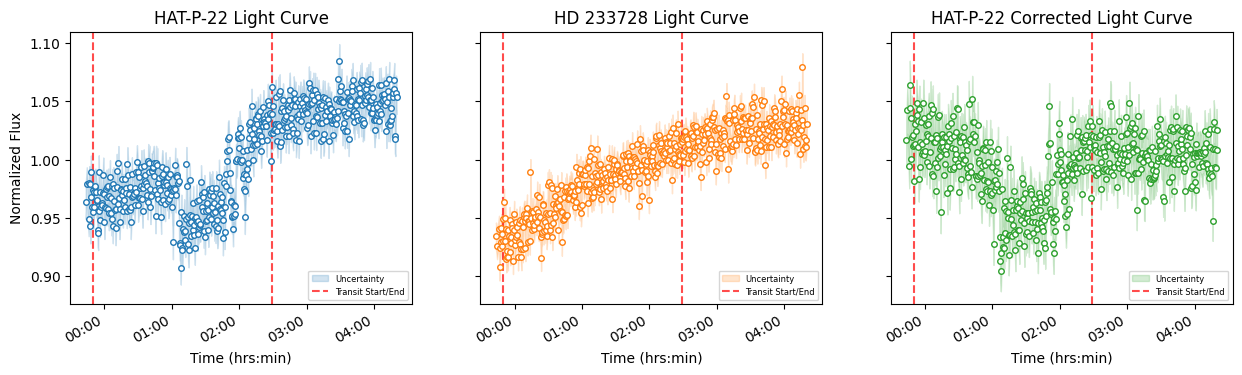

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

ax1.fill_between(pst_datetime, normalized_flux - normalized_flux_err, normalized_flux + normalized_flux_err, color='tab:blue', alpha=0.2, label='Uncertainty')
ax1.errorbar(pst_datetime, normalized_flux, marker='o', mfc='white', markersize=4, color='tab:blue', linestyle='None',
            #yerr = normalized_flux_err, capsize = 2, elinewidth = 1,
            )
ax1.set_title(f'{Star_Name} Light Curve')



ax2.fill_between(pst_datetime, normalized_comp - normalized_comp_err, normalized_comp + normalized_comp_err, color='tab:orange', alpha=0.2, label='Uncertainty')
ax2.errorbar(pst_datetime, normalized_comp, marker='o', mfc='white', markersize=4, color='tab:orange', linestyle='None',
            #yerr = normalized_comp_err, capsize = 2, elinewidth = 1,
            )
ax2.set_title(f'{Comp_Star_Name} Light Curve')



ax3.fill_between(pst_datetime, normalized_relative_flux - normalized_relative_flux_err, normalized_relative_flux + normalized_relative_flux_err, color='tab:green', alpha=0.2, label='Uncertainty')
ax3.errorbar(pst_datetime, normalized_relative_flux, marker='o', mfc='white', markersize=4, color='tab:green', linestyle='None',
            #yerr = normalized_relative_flux_err, capsize = 2, elinewidth = 1,
            )
ax3.set_title(f'{Star_Name} Corrected Light Curve')

for ax in [ax1, ax2, ax3]:
    #ax.set_ylim(0.7, 1.2)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    ax.axvline(x=transit_end, color='red', linestyle='--', alpha=0.7,)
    ax.axvline(x=transit_start, color='red', linestyle='--', alpha=0.7, label='Transit Start/End')
    
    ax.set_xlabel('Time (hrs:min)')
    if ax == ax1:
        ax.set_ylabel('Normalized Flux') 
    ax.legend(fontsize = 6, loc='lower right')

fig.autofmt_xdate()

plt.savefig(f'../graphs/{Star_Name}_{Comp_Star_Name}-Light_Curves.png', dpi=300, bbox_inches='tight')

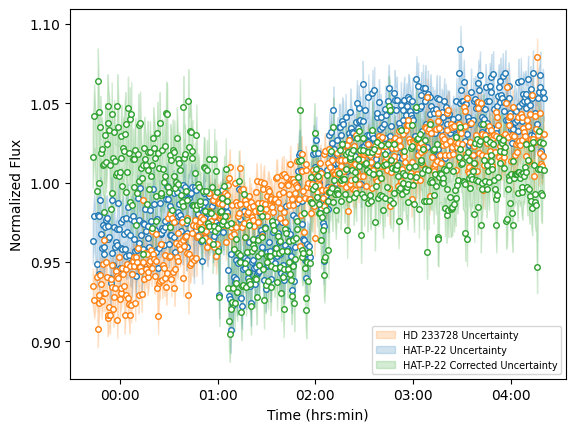

In [18]:
plt.figure()

ax1.set_title(f'{Star_Name} Light Curve')
ax2.set_title(f'{Comp_Star_Name} Light Curve')
ax3.set_title(f'{Star_Name} Corrected Light Curve')

plt.fill_between(pst_datetime, normalized_comp - normalized_comp_err, normalized_comp + normalized_comp_err, color='tab:orange', alpha=0.2, label=f'{Comp_Star_Name} Uncertainty')
plt.fill_between(pst_datetime, normalized_flux - normalized_flux_err, normalized_flux + normalized_flux_err, color='tab:blue', alpha=0.2, label=f'{Star_Name} Uncertainty')
plt.fill_between(pst_datetime, normalized_relative_flux - normalized_relative_flux_err, normalized_relative_flux + normalized_relative_flux_err, color='tab:green', alpha=0.2, label=f'{Star_Name} Corrected Uncertainty')

plt.errorbar(pst_datetime, normalized_flux, marker='o', mfc='white', markersize=4, color='tab:blue', linestyle='None',
            #yerr = normalized_flux_err, capsize = 2, elinewidth = 1, alpha = 0.4
            )
plt.errorbar(pst_datetime, normalized_comp, marker='o', mfc='white', markersize=4, color='tab:orange', linestyle='None',
            #yerr = normalized_comp_err, capsize = 2, elinewidth = 1, alpha = 0.4
            )
plt.errorbar(pst_datetime, normalized_relative_flux, marker='o', mfc='white', markersize=4, color='tab:green', linestyle='None',
            #yerr = normalized_relative_flux_err, capsize = 2, elinewidth = 1, alpha = 0.4
            )

#plt.plot(pst_datetime, normalized_flux, marker='o', mfc='white', markersize=4, color='tab:blue', linestyle='None', label = f'{Star_Name} Light Curve')
#plt.plot(pst_datetime, normalized_comp, marker='o', mfc='white', markersize=4, color='tab:orange', linestyle='None', label = f'{Comp_Star_Name} Light Curve')
#plt.plot(pst_datetime, normalized_relative_flux, marker='o', mfc='white', markersize=4, color='tab:green', linestyle='None', label = f'{Star_Name} Corrected Light Curve')



plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#plt.ylim(0.7, 1.7)
plt.xlabel('Time (hrs:min)')
plt.ylabel('Normalized Flux')

plt.legend(fontsize=7, loc='lower right')
plt.savefig(f'../graphs/{Star_Name}_{Comp_Star_Name}-Combined-Light_Curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculating Exoplanet Size
By measuring the transit depth and knowing the stellar radius, it is possible to determine the radius of the exoplanet using the equation

$$
\frac {\Delta L}{L} = \left ( \frac {R_P}{R_*} \right) ^2 \implies R_P = R_*\sqrt{\frac{\Delta L}{L}} = R_* \times \text{Transit Depth}
$$

Where $\frac{\Delta L}{L}$ is the change in flux, $R_P$ is the exoplanet radius, and $R_*$ is the star's radius.

## Uncertainty in Calculation
The uncertainty in this calculation is calculated by

$$
\text{Uncertainty} = \sqrt{\left( \frac{\sigma_\text{out}}{\sqrt{N_\text{out}}} \right)^2 +\left(\frac{\sigma_\text{in}}{\sqrt{N_\text{in}}} \right)^2}
$$

In [19]:
R_sun_km = 696340      #radius of Sun in km
R_jup_km = 69911       #radius of Jupiter in km
R_star_solar = 1.062   #Radius of target star in solar radii 
accepted_radius = 1.15 #accepted radius of exoplanet in Jupiter radii

R_star_km = R_star_solar * R_sun_km
t_start_obj = (Time(transit_start, format='mjd'))
t_end_obj   = (Time(transit_end,   format='mjd'))
t = Time(pst_datetime) 
unix_days = t.unix / 86400.0


transit_mask = (unix_days > transit_start) & (unix_days < transit_end)

baseline_flux = np.median(relative_flux[~transit_mask]) 
normalized_flux = relative_flux / baseline_flux

flux_in_transit = normalized_flux[transit_mask]
flux_out_transit = normalized_flux[~transit_mask]

transit_depth = np.median(flux_out_transit) - np.median(flux_in_transit)



planet_radius_km = R_sun_km * np.sqrt(transit_depth)
planet_radius_jup = planet_radius_km / R_jup_km



error_percent = abs((planet_radius_jup - accepted_radius) / accepted_radius) * 100


### Calculating uncertainties. Use standard error
SE_out = (np.std(flux_out_transit))/(len(flux_out_transit))
SE_in = (np.std(flux_in_transit))/(len(flux_in_transit))
transit_depth_error = (np.sqrt((SE_out**2)+(SE_in)**2))

err_planet_radius_km = np.abs((R_sun_km * np.sqrt(transit_depth+transit_depth_error))-planet_radius_km)
err_planet_radius_jup = np.abs(((planet_radius_km + err_planet_radius_km)/R_jup_km) - planet_radius_jup)

print(f"Transit Depth: ({(transit_depth*100):.2f} +/- {(transit_depth_error*100):.1})%")
print(f"Planet Radius: {planet_radius_jup:.3f} +/- {err_planet_radius_jup:.3f} Jupiter Radii")

print(f"\nAccepted Radius: {accepted_radius} Jupiter Radii")
print(f"Percent Error: {error_percent:.1f}%")

Transit Depth: (1.39 +/- 0.01)%
Planet Radius: 1.176 +/- 0.005 Jupiter Radii

Accepted Radius: 1.15 Jupiter Radii
Percent Error: 2.2%
